In [1]:
#import prody as pr
#import numpy as np
import os
import subprocess
#import rdkit as rd
#from rdkit import Chem
#from rdkit.Chem import AllChem
#from tqdm.auto import tqdm
import pandas as pd
#import math
#from meeko import MoleculePreparation
#from meeko import PDBQTWriterLegacy


In [10]:
! pwd

/home/ramin/Desktop/personal/cheminfo/met


## helper functions

In [11]:
# this list is to make sure that we only use the supported charachters by autogrid
supported_atypes = ['HD', 'C', 'A', 'N', 'NA', 'OA', 'F', 'P', 'SA', 'S',
                    'Cl', 'Br', 'I', 'Mg', 'Ca', 'Mn', 'Fe', 'Zn']

# the structure of the gpf file for autogrid4 as p
gpf = """npts NPTS_X NPTS_Y NPTS_Z
gridfld r.maps.fld
spacing 0.375
receptor_types RECTYPES
ligand_types HD C A N NA OA F P SA S Cl Br I
receptor r.pdbqt
gridcenter CENTER_X CENTER_Y CENTER_Z
smooth 0.5
map         r.HD.map
map         r.C.map
map         r.A.map
map         r.N.map
map         r.NA.map
map         r.OA.map
map         r.F.map
map         r.P.map
map         r.SA.map
map         r.S.map
map         r.Cl.map
map         r.Br.map
map         r.I.map
elecmap     r.e.map
dsolvmap    r.d.map
dielectric -0.1465
"""


vina_config = """
center_x = CENTER_X
center_y = CENTER_Y
center_z = CENTER_Z
size_x = SIZE_X
size_y = SIZE_Y
size_z = SIZE_Z
"""

In [55]:
def getrectypes(fname):
    command = 'cut -c 77-79 %s | sort -u' % fname
    out = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    out = out.communicate()[0]
    rectypes = []
    for atype in out.split():
        atype = atype.strip().decode()
        if atype in supported_atypes:
            rectypes.append(atype)
    return ' '.join(rectypes)


# calculating grid box from the ligand size 
def calcbox(fname, pad, spacing=0.375) -> list:
    x_min = float('inf')
    y_min = float('inf')
    z_min = float('inf')
    x_max = float('-inf')
    y_max = float('-inf')
    z_max = float('-inf')
    with open(fname) as f:
        for line in f:
            if line.startswith('ATOM') or line.startswith('HETATM'):
                x = float(line[30:38])
                y = float(line[38:46])
                z = float(line[46:54])
                x_max = max(x, x_max)
                y_max = max(y, y_max)
                z_max = max(z, z_max)
                x_min = min(x, x_min)
                y_min = min(y, y_min)
                z_min = min(z, z_min)
    center_x = (x_min + x_max) / 2.0
    center_y = (y_min + y_max) / 2.0
    center_z = (z_min + z_max) / 2.0
    npts_x = math.ceil((2 * pad + x_max - x_min) / spacing)  
    npts_y = math.ceil((2 * pad + y_max - y_min) / spacing)  
    npts_z = math.ceil((2 * pad + z_max - z_min) / spacing)  
    return [center_x, center_y, center_z, npts_x, npts_y, npts_z]


# this function writes the grid info for vina, vina algo dont accept map
def vina_conf(center_x, center_y, center_z,npts_x, npts_y, npts_z) -> list:
    center_x = center_x
    center_y = center_y
    center_z = center_z
    size_x = (npts_x * 0.75) / 2
    size_y = (npts_y * 0.75) / 2
    size_z = (npts_z * 0.75) / 2
    return [center_x, center_y, center_z, size_x, size_y, size_z]



def write_vinaconf_gpf(lPDBQT, rPDBQT, p, gpf=gpf, vconf=vina_config, gpf_out='./r.gpf', v_out='./v.txt'):
    rrectypes = getrectypes(rPDBQT)
    gridbox: list = calcbox(lPDBQT, p)
    vina_config: list = vina_conf(*gridbox)


    gpf = gpf.replace('RECTYPES',   rrectypes)
    gpf = gpf.replace('NPTS_X',     '%d' % gridbox[3])
    gpf = gpf.replace('NPTS_Y',     '%d' % gridbox[4])
    gpf = gpf.replace('NPTS_Z',     '%d' % gridbox[5])
    gpf = gpf.replace('CENTER_X',   '%.3f' % gridbox[0])
    gpf = gpf.replace('CENTER_Y',   '%.3f' % gridbox[1])
    gpf = gpf.replace('CENTER_Z',   '%.3f' % gridbox[2])
    
    vconf = vconf.replace('CENTER_X',   '%d' % vina_config[0])
    vconf = vconf.replace('CENTER_Y',   '%d' % vina_config[1])
    vconf = vconf.replace('CENTER_Z',   '%d' % vina_config[2])
    vconf = vconf.replace('SIZE_X',     '%d' % vina_config[3])
    vconf = vconf.replace('SIZE_Y',     '%d' % vina_config[4])
    vconf = vconf.replace('SIZE_Z',     '%d' % vina_config[5])

    with open(gpf_out, 'w') as f:
        f.write(gpf)
    with open(v_out, 'w') as f:
        f.write(vconf)

def run_autogrid(gpf, glgout='./r.glg'):
    command = f'autogrid4 -p {gpf} -l {glgout}'
    subprocess.run(command ,shell=True, stdout=subprocess.PIPE)
    print('success, map files created sucsussfully!')
    return 1

def run_prepare_receptor(rPDB):
    command = f'prepare_receptor -r {rPDB} -o r.pdbqt'
    try:
        subprocess.run(command, shell=True, stdout=subprocess.PIPE)
        print("success")
        return 1
    except Exception as e:
        print(f"error:{str(e)}")
        return 0

def run_obabel_ligand(lPDB):
    command_1 = f'obabel -ipdb {lPDB} -osdf -O ./l_with_no_h.sdf'
    subprocess.run(command_1, shell=True, stdout=subprocess.PIPE)
    return 1

def run_prepare_ligand(lSDF):
    command = f'mk_prepare_ligand.py -i {lSDF} -o l.pdbqt'
    subprocess.run(command, shell=True, stdout=subprocess.PIPE)
    return 1

def obabel_receptor(rPDB):
    command = f'obabel -i pdb {rPDB} -opdb -O ./r.pdb -h'
    subprocess.run(command, shell=True, stdout=subprocess.PIPE)
    return 1

In [13]:
def prepare_lig_rec(this_time, out=("./r.pdb", "./l.pdb")):
    mainPbd = pr.parsePDB(pr.fetchPDB(this_time, compressed=False)) # fetches the pdb file
    chains = mainPbd.getChids() # seprates the chain
    receptor = mainPbd.select('chain A protein') # lets hope there's always a A chain!
    pr.writePDB(out[0], receptor) # save the chain A as r.pdb
    # I encountered some problems with rdkit adding Hs to rec I decided to use obabel with -h flag
    # mol = rd.Chem.MolFromPDBFile('./r.pdb') # load the r.pdb in order to add hydrogens
    # receptor_H = rd.Chem.AddHs(mol, addCoords=True, addResidueInfo=True) # add Hs
    # rd.Chem.PDBWriter('./r.pdb').write(receptor_H) # write the hydrogenated r.pdb
    obabel_receptor(out[0])
    try:
        ligands = mainPbd.select('chain A not protein not water') # seprate the small molecules
        res, count = np.unique(ligands.getResnames(), return_counts=True) # as my experience the most reapeted name in .getResname method output is the main ligand 
        dict_res_count = dict(zip(res, count)) # create a dict from the resnames and there count
        main_res = list(dict_res_count.keys())[list(dict_res_count.values()).index(max(dict_res_count.values()))] # chose the most reapeted one
        ligand = ligands.select(f'resname {main_res}')
        pr.writePDB(out[1], ligand)
    except:
        return "No ligands"

In [14]:
def addHs(input_sdf, output_sdf): ## to ligand
    try:
        suppl = rd.Chem.SDMolSupplier(input_sdf, sanitize=False)
        mol = next(suppl)
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() == 7 and atom.GetTotalValence() == 4: # 7fcz
                atom.SetFormalCharge(1)  # Assuming it's supposed to be NH4+
        rd.Chem.SanitizeMol(mol)  # Re-sanitize after making adjustments

        ligand_H = rd.Chem.AddHs(mol, addCoords=True)
        
        writer = rd.Chem.SDWriter(output_sdf)
        writer.write(ligand_H)
        writer.close()
        print("now the small molecule has Hs")
        return 1
    except Exception as e:
        print(f"an error occured, {str(e)}")

In [15]:
os.getcwd()

'/home/ramin/Desktop/personal/cheminfo/met'

In [6]:
os.chdir("./savolotinib_6SDE/")

In [17]:
def ligand_prep(ligmol, out):
    '''
    input:
    :ligmol: RDkit mol
    :out: output path and name
    output:
    :pdbqt: writes a pdbfile to the working directory
    '''
    mol_Hs = Chem.AddHs(ligmol, addCoords=True)
    AllChem.EmbedMolecule(mol_Hs, AllChem.ETKDG())
    AllChem.MMFFOptimizeMolecule(mol_Hs)
    preparator = MoleculePreparation(merge_these_atom_types=("H",))
    mol_setup = preparator.prepare(mol_Hs)[0]
    pdbqt_string, is_ok, error_msg = PDBQTWriterLegacy.write_string(mol_setup)
    if is_ok:
            #print(type(pdbqt_string) ,pdbqt_string, end="")
        with open(f'{out}.pdbqt', 'w') as pdbqt:
            pdbqt.writelines(pdbqt_string)
        return 1
    if not is_ok:
        return 0, str(error_msg)

    
    

In [36]:
def dock_lig(lPDBQT, MAPS, name):
    '''
    just runs autodock gpu with the specified lig
    and maps file
    input:
    :lPDBQT: path to the ligand in pdbqt format
    :MAPS: path to the r.maps.fld
    output:
    :l.dlg: whcich is the result of the dockig simulations
    '''
    command = f"/home/ramin/Downloads/AutoDock-GPU/bin/autodock_gpu_64wi --lfile {lPDBQT} --ffile {MAPS} --nrun 50 --resname {name}"
    p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    p.communicate()
    

## main part

### validation

In [31]:
prepare_lig_rec("2wkm", out=("./wild/r.pdb", "./wild/l.pdb"))

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 2wkm downloaded (2wkm.pdb)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 2492 atoms and 1 coordinate set(s) were parsed in 0.02s.
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is ./wild/r.pdb)

1 molecule converted


In [65]:
os.chdir("../wild")

In [66]:
! pwd

/home/ramin/Desktop/personal/cheminfo/met/wild


In [67]:
! prepare_receptor -r r.pdb -o r.pdbqt

adding gasteiger charges to peptide


In [68]:
run_obabel_ligand('./l.pdb')

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is ./l.pdb)

1 molecule converted


1

In [69]:
addHs('./l_with_no_h.sdf', 'l_out.sdf')

now the small molecule has Hs


1

In [70]:
run_prepare_ligand('./l_out.sdf')

1

In [71]:
write_vinaconf_gpf('l.pdbqt', 'r.pdbqt', 10)

In [73]:
! obabel -i pdb ../r.pdb -opdb -O ./r.pdb -h

1 molecule converted


In [74]:
! prepare_receptor -r r.pdb -o r.pdbqt

adding gasteiger charges to peptide


In [75]:
write_vinaconf_gpf('l.pdbqt', 'r.pdbqt', 10)

In [76]:
! autogrid4 -p r.gpf -l r.glg

In [78]:
! adgpu --lfile l.pdbqt --ffile r.maps.fld --nrun 50

AutoDock-GPU version: v1.5.3-104-g2e658c318d60806bc6bb361f11f8535d5fb1fe1f

Running 1 docking calculation

Cuda device:                              NVIDIA GeForce MX450
Available memory on device:               1627 MB (total: 1685 MB)

CUDA Setup time 0.224820s
(Thread 6 is setting up Job #1)

Running Job #1
    Using heuristics: (capped) number of evaluations set to 702259
    Local-search chosen method is: ADADELTA (ad)

Rest of Setup time 0.038241s

Executing docking runs, stopping automatically after either reaching 0.15 kcal/mol standard deviation of
the best molecules of the last 4 * 5 generations, 42000 generations, or 702259 evaluations:

Generations |  Evaluations |     Threshold    |  Average energy of best 10%  | Samples | Best Inter + Intra
------------+--------------+------------------+------------------------------+---------+-------------------
          0 |          150 |   -0.85 kcal/mol |   -3.13 +/-    0.61 kcal/mol |       4 |   -4.03 kcal/mol
          5 |        

In [79]:
os.chdir("../mutant/")

In [80]:
! pwd

/home/ramin/Desktop/personal/cheminfo/met/mutant


In [81]:
obabel_receptor('/home/ramin/Downloads/results_20241011-1434-AC75EF/mutant_structures/2wkm_m.pdb')

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /home/ramin/Downloads/results_20241011-1434-AC75EF/mutant_structures/2wkm_m.pdb)

1 molecule converted


1

In [82]:
! prepare_receptor -r r.pdb -o r.pdbqt

adding gasteiger charges to peptide


In [83]:
write_vinaconf_gpf('../wild/l.pdbqt', 'r.pdbqt', 10)

In [84]:
! autogrid4 -p r.gpf -l r.glg

In [85]:
! cp ../wild/l.pdbqt ./

In [86]:
! adgpu --lfile l.pdbqt --ffile r.maps.fld --nrun 50

AutoDock-GPU version: v1.5.3-104-g2e658c318d60806bc6bb361f11f8535d5fb1fe1f

Running 1 docking calculation

Cuda device:                              NVIDIA GeForce MX450
Available memory on device:               1627 MB (total: 1685 MB)

CUDA Setup time 0.218950s
(Thread 6 is setting up Job #1)

Running Job #1
    Using heuristics: (capped) number of evaluations set to 702259
    Local-search chosen method is: ADADELTA (ad)

Rest of Setup time 0.036315s

Executing docking runs, stopping automatically after either reaching 0.15 kcal/mol standard deviation of
the best molecules of the last 4 * 5 generations, 42000 generations, or 702259 evaluations:

Generations |  Evaluations |     Threshold    |  Average energy of best 10%  | Samples | Best Inter + Intra
------------+--------------+------------------+------------------------------+---------+-------------------
          0 |          150 |   -2.62 kcal/mol |   -3.45 +/-    0.22 kcal/mol |       4 |   -3.81 kcal/mol
          5 |        

In [64]:
! pwd

/home/ramin/Desktop/personal/cheminfo/met/mutant


In [2]:
drug_df = pd.read_csv("../all_fda_approved.csv")

In [3]:
drug_df.head()

,molecule_chembl_id,SMILES,name
0,CHEMBL2,COc1cc2nc(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC,PRAZOSIN
1,CHEMBL3,CN1CCC[C@H]1c1cccnc1,NICOTINE
2,CHEMBL4,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,OFLOXACIN
3,CHEMBL5,CCn1cc(C(=O)O)c(=O)c2ccc(C)nc21,NALIDIXIC ACID
4,CHEMBL6,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,INDOMETHACIN


In [4]:
with open("./drugs_smi.smi", "w") as f:
    f.writelines((f"{i}\n" for i in drug_df.SMILES.values))

In [ ]:
! ../gypsum_dl/run_gypsum_dl.py --source ./cleaner_drugs.smi --skip_making_tautomers --skip_enumerate_chiral_mol --skip_enumerate_double_bonds --skip_alternate_ring_conformations --job_manager multiprocessing --num_processors 4 -m 1


If you use Gypsum-DL in your research, please cite:

Ropp, Patrick J., Jacob O. Spiegel, Jennifer L. Walker, Harrison Green,
Guillermo A. Morales, Katherine A. Milliken, John J. Ringe, and Jacob D. Durrant.
(2019) Gypsum-DL: An Open-source Program for Preparing Small-molecule Libraries for 
Structure-based Virtual Screening. Journal of Cheminformatics 11:1. 
doi:10.1186/s13321-019-0358-3.

    Gypsum-DL-generated variants, we have identified a number of substructures
    that, though technically possible, strike us as improbable or otherwise
    poorly suited for virtual screening. We strongly recommend removing these by
    running Gypsum-DL with the --use_durrant_lab_filters option.

Loading molecules from cleaner_drugs.smi...
    Untitled ligand on line 1. Naming that ligand untitled_line_1. All
        associated files will be referred to with this name.
    Untitled ligand on line 2. Naming that ligand untitled_line_2. All
        associated files will be referred to with this na

In [7]:
prepare_lig_rec("2wgj", out=("./Crizotinib, 2wgj/wild/r.pdb", "./Crizotinib, 2wgj/wild/l.pdb"))

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 2wgj downloaded (2wgj.pdb)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 2519 atoms and 1 coordinate set(s) were parsed in 0.02s.
*** Open Babel Error  in OpenAndSetFormat
  Cannot open ./Crizotinib,
*** Open Babel Error  in OpenAndSetFormat
  Cannot open 2wgj/wild/r.pdb
0 molecules converted


In [8]:
os.chdir("./Crizotinib, 2wgj/wild")

In [9]:
!pwd

/home/ramin/Desktop/personal/cheminfo/met/Crizotinib, 2wgj/wild


In [10]:
obabel_receptor("./r.pdb")

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is ./r.pdb)

1 molecule converted


1

In [11]:
! prepare_receptor -r r.pdb -o r.pdbqt

adding gasteiger charges to peptide


In [12]:
run_obabel_ligand('./l.pdb')

1 molecule converted


1

In [13]:
addHs('./l_with_no_h.sdf', 'l_out.sdf')

now the small molecule has Hs


1

In [14]:
run_prepare_ligand('./l_out.sdf')

1

In [15]:
write_vinaconf_gpf('l.pdbqt', 'r.pdbqt', 10)

In [17]:
! autogrid4 -p r.gpf -l r.glg

In [18]:
! adgpu --lfile l.pdbqt --ffile r.maps.fld --nrun 50

AutoDock-GPU version: v1.5.3-104-g2e658c318d60806bc6bb361f11f8535d5fb1fe1f

Running 1 docking calculation

Cuda device:                              NVIDIA GeForce MX450
Available memory on device:               1627 MB (total: 1685 MB)

CUDA Setup time 0.225939s
(Thread 7 is setting up Job #1)

Running Job #1
    Using heuristics: (capped) number of evaluations set to 480000
    Local-search chosen method is: ADADELTA (ad)

Rest of Setup time 0.031467s

Executing docking runs, stopping automatically after either reaching 0.15 kcal/mol standard deviation of
the best molecules of the last 4 * 5 generations, 42000 generations, or 480000 evaluations:

Generations |  Evaluations |     Threshold    |  Average energy of best 10%  | Samples | Best Inter + Intra
------------+--------------+------------------+------------------------------+---------+-------------------
          0 |          150 |   -1.48 kcal/mol |   -2.77 +/-    0.43 kcal/mol |       5 |   -3.39 kcal/mol
          5 |        

In [19]:
os.chdir("../mutant/")

In [20]:
obabel_receptor("./r.pdb")

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is ./r.pdb)

1 molecule converted


1

In [21]:
! prepare_receptor -r r.pdb -o r.pdbqt

adding gasteiger charges to peptide


In [22]:
! cp ../wild/l.pdbqt ./

In [23]:
write_vinaconf_gpf('l.pdbqt', 'r.pdbqt', 10)

In [24]:
! autogrid4 -p r.gpf -l r.glg

In [25]:
! adgpu --lfile l.pdbqt --ffile r.maps.fld --nrun 50

AutoDock-GPU version: v1.5.3-104-g2e658c318d60806bc6bb361f11f8535d5fb1fe1f

Running 1 docking calculation

Cuda device:                              NVIDIA GeForce MX450
Available memory on device:               1627 MB (total: 1685 MB)

CUDA Setup time 0.216063s
(Thread 6 is setting up Job #1)

Running Job #1
    Using heuristics: (capped) number of evaluations set to 480000
    Local-search chosen method is: ADADELTA (ad)

Rest of Setup time 0.028372s

Executing docking runs, stopping automatically after either reaching 0.15 kcal/mol standard deviation of
the best molecules of the last 4 * 5 generations, 42000 generations, or 480000 evaluations:

Generations |  Evaluations |     Threshold    |  Average energy of best 10%  | Samples | Best Inter + Intra
------------+--------------+------------------+------------------------------+---------+-------------------
          0 |          150 |   -1.87 kcal/mol |   -3.06 +/-    0.32 kcal/mol |       4 |   -3.50 kcal/mol
          5 |        

In [26]:
os.chdir("../../savolotinib_6SDE/")

In [27]:
prepare_lig_rec("6SDE")

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 6sde downloaded (6sde.pdb)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 2215 atoms and 1 coordinate set(s) were parsed in 0.03s.
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is ./r.pdb)

1 molecule converted


In [28]:
os.chdir("./wild")

In [29]:
obabel_receptor("./r.pdb")

1 molecule converted


1

In [30]:
! prepare_receptor -r r.pdb -o r.pdbqt

adding gasteiger charges to peptide


In [31]:
run_obabel_ligand('./l.pdb')

1 molecule converted


1

In [32]:
addHs('./l_with_no_h.sdf', 'l_out.sdf')

now the small molecule has Hs


1

In [33]:
run_prepare_ligand('l_out.sdf')

1

In [34]:
write_vinaconf_gpf('l.pdbqt', 'r.pdbqt', 10)

In [35]:
! autogrid4 -p r.gpf -l r.glg

In [36]:
! adgpu --lfile l.pdbqt --ffile r.maps.fld --nrun 50

AutoDock-GPU version: v1.5.3-104-g2e658c318d60806bc6bb361f11f8535d5fb1fe1f

Running 1 docking calculation

Cuda device:                              NVIDIA GeForce MX450
Available memory on device:               1627 MB (total: 1685 MB)

CUDA Setup time 0.219292s
(Thread 5 is setting up Job #1)

Running Job #1
    Using heuristics: (capped) number of evaluations set to 480000
    Local-search chosen method is: ADADELTA (ad)

Rest of Setup time 0.028699s

Executing docking runs, stopping automatically after either reaching 0.15 kcal/mol standard deviation of
the best molecules of the last 4 * 5 generations, 42000 generations, or 480000 evaluations:

Generations |  Evaluations |     Threshold    |  Average energy of best 10%  | Samples | Best Inter + Intra
------------+--------------+------------------+------------------------------+---------+-------------------
          0 |          150 |   -0.59 kcal/mol |   -2.11 +/-    0.49 kcal/mol |      12 |   -3.51 kcal/mol
          5 |        

In [37]:
os.chdir("../mutant/")

In [38]:
obabel_receptor('./r.pdb')

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is ./r.pdb)

1 molecule converted


1

In [39]:
run_prepare_receptor('./r.pdb')

success


1

In [40]:
! cp ../wild/l.pdbqt ./

In [41]:
write_vinaconf_gpf('l.pdbqt', 'r.pdbqt', 10)

In [42]:
run_autogrid('r.gpf')

success, map files created sucsussfully!


1

In [43]:
! adgpu --lfile l.pdbqt --ffile r.maps.fld --nrun 50

AutoDock-GPU version: v1.5.3-104-g2e658c318d60806bc6bb361f11f8535d5fb1fe1f

Running 1 docking calculation

Cuda device:                              NVIDIA GeForce MX450
Available memory on device:               1627 MB (total: 1685 MB)

CUDA Setup time 0.220304s
(Thread 5 is setting up Job #1)

Running Job #1
    Using heuristics: (capped) number of evaluations set to 480000
    Local-search chosen method is: ADADELTA (ad)

Rest of Setup time 0.027995s

Executing docking runs, stopping automatically after either reaching 0.15 kcal/mol standard deviation of
the best molecules of the last 4 * 5 generations, 42000 generations, or 480000 evaluations:

Generations |  Evaluations |     Threshold    |  Average energy of best 10%  | Samples | Best Inter + Intra
------------+--------------+------------------+------------------------------+---------+-------------------
          0 |          150 |    1.05 kcal/mol |   -1.36 +/-    0.60 kcal/mol |      32 |   -4.18 kcal/mol
          5 |        

In [44]:
sav_smiles = "C[C@@H](c1ccc2nccn2c1)n1nnc2ncc(-c3cnn(C)c3)nc21"

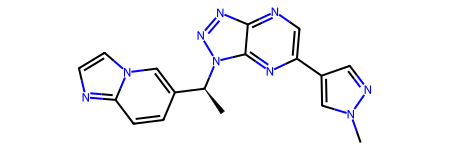

In [45]:
Chem.MolFromSmiles(sav_smiles)

In [47]:
swiss_df = pd.read_csv("/home/ramin/Downloads/full_out_sav.csv")

In [48]:
swiss_df.head()

,Unnamed: 0,Phase,S_method,Molecule_ID,Score
0,476,CHEMBL_clinic,2D - ECFP4,CHEMBL3334567,1.0
1,480,CHEMBL_clinic,2D - MHFP6,CHEMBL3334567,1.0
2,487,CHEMBL_clinic,2D - Pharmacophore,CHEMBL3334567,1.0
3,521,CHEMBL_clinic,2D - ErG,CHEMBL3334567,1.0
4,473,CHEMBL_clinic,2D - FP2,CHEMBL3334567,1.0


In [50]:
swiss_df.dtypes

Unnamed: 0       int64
Phase           object
S_method        object
Molecule_ID     object
Score          float64
dtype: object

In [55]:
swidd_df = (swiss_df
 .drop('Unnamed: 0', axis=1)
 .drop_duplicates("Molecule_ID")
 .astype({'Phase':'category', 'S_method': 'category', 'Molecule_ID':'string'})
 .query('Phase == "CHEMBL_drug"')
 .drop('Phase', axis=1)
 .reset_index(drop=True)
)

In [57]:
swiss_df = swidd_df

In [58]:
swiss_df.head()

,S_method,Molecule_ID,Score
0,3D - Electroshape,CHEMBL1257015,0.880
1,3D - Electroshape,CHEMBL473417,0.876
2,3D - Electroshape,CHEMBL2368925,0.871
3,3D - Electroshape,CHEMBL3301607,0.862
4,3D - Electroshape,CHEMBL1521,0.862


In [59]:
swiss_df.shape

(406, 3)

In [62]:
swiss_df.S_method.unique()

['3D - Electroshape', '2D - ErG', '2D - Pharmacophore', '2D & 3D combined']
Categories (6, object): ['2D & 3D combined', '2D - ECFP4', '2D - ErG', '2D - FP2', '2D - Pharmacophore', '3D - Electroshape']

In [63]:
(swiss_df
 .query("S_method == '2D - Pharmacophore'")
)

,S_method,Molecule_ID,Score
62,2D - Pharmacophore,CHEMBL3188267,0.479
63,2D - Pharmacophore,CHEMBL3989937,0.479
64,2D - Pharmacophore,CHEMBL2107834,0.371
65,2D - Pharmacophore,CHEMBL3545376,0.365
66,2D - Pharmacophore,CHEMBL3813873,0.350
67,2D - Pharmacophore,CHEMBL3989973,0.350


In [65]:
from chembl_webresource_client.new_client import new_client

In [66]:
mol = new_client.molecule

In [97]:
smiles = mol.filter(molecule_chembl_id__in=swiss_df.Molecule_ID.values.tolist()).only('molecule_structures', 'molecule_chembl_id', 'pref_name')

In [98]:
smiles_list = list(tqdm(smiles))

  0%|          | 0/405 [00:00<?, ?it/s]

In [99]:
smiles_list_df = pd.DataFrame.from_records(smiles_list)

In [100]:
smiles_list_df.head()

,molecule_chembl_id,molecule_structures,pref_name
0,CHEMBL6437,{'canonical_smiles': 'CN1CCN2c3ccccc3Cc3ccccc3...,MIANSERIN
1,CHEMBL406,{'canonical_smiles': 'CC1Cc2ccccc2N1NC(=O)c1cc...,INDAPAMIDE
2,CHEMBL407,{'canonical_smiles': 'CCOC(=O)c1ncn2c1CN(C)C(=...,FLUMAZENIL
3,CHEMBL12,{'canonical_smiles': 'CN1C(=O)CN=C(c2ccccc2)c2...,DIAZEPAM
4,CHEMBL16,{'canonical_smiles': 'O=C1NC(=O)C(c2ccccc2)(c2...,PHENYTOIN


In [101]:
smiles_list_df['SMILES'] = smiles_list_df.molecule_structures.apply(lambda x: x['canonical_smiles'])

In [102]:
smiles_list_df.drop('molecule_structures', axis=1, inplace=True)

In [103]:
smiles_list_df = (smiles_list_df
                  .rename(columns={'molecule_chembl_id': 'Molecule_ID'})
                 )

In [104]:
swiss_df = pd.merge(
    swiss_df,
    smiles_list_df,
    on='Molecule_ID'
)

In [105]:
swiss_df.shape

(405, 6)

In [111]:
swiss_df = (swiss_df
            .drop('SMILES_y', axis=1)
            .rename(columns={'SMILES_x': 'SMILES'})
           )

In [112]:
swiss_df.head()

,S_method,Molecule_ID,Score,SMILES,pref_name
0,3D - Electroshape,CHEMBL1257015,0.880,COc1ccc(C(=O)NCc2cccnc2)cc1C(=O)NCc1cccnc1,PICOTAMIDE
1,3D - Electroshape,CHEMBL473417,0.876,CS(=O)(=O)c1ccc(C(=O)Nc2ccc(Cl)c(-c3ccccn3)c2)...,VISMODEGIB
2,3D - Electroshape,CHEMBL2368925,0.871,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,DOLASETRON
3,3D - Electroshape,CHEMBL3301607,0.862,O=C(Nc1nc2cccc(-c3ccc(CN4CCS(=O)(=O)CC4)cc3)n2...,FILGOTINIB
4,3D - Electroshape,CHEMBL1521,0.862,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,ZALEPLON


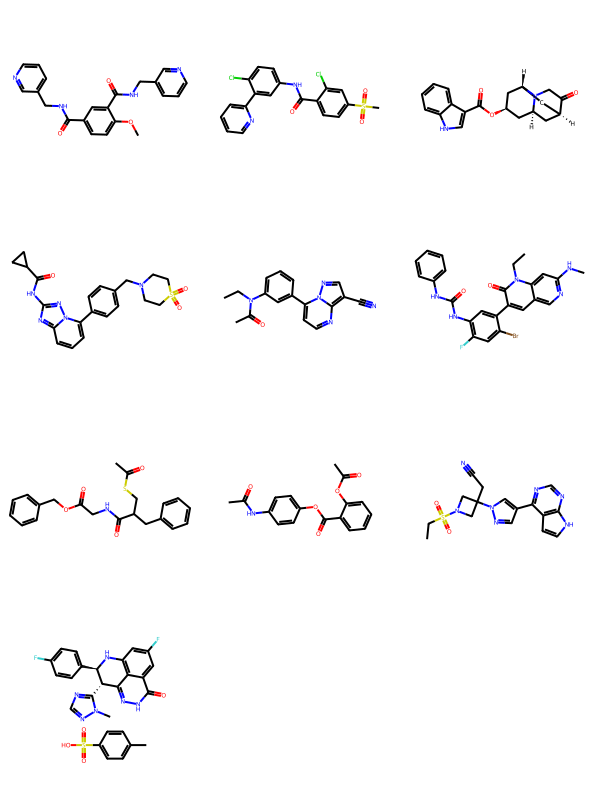

In [115]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in swiss_df.SMILES.values[0:10]])

In [116]:
swiss_df['SMILES'] = (swiss_df
                      .SMILES
                      .apply(lambda x: max(x.split("."), key=len))
                     )

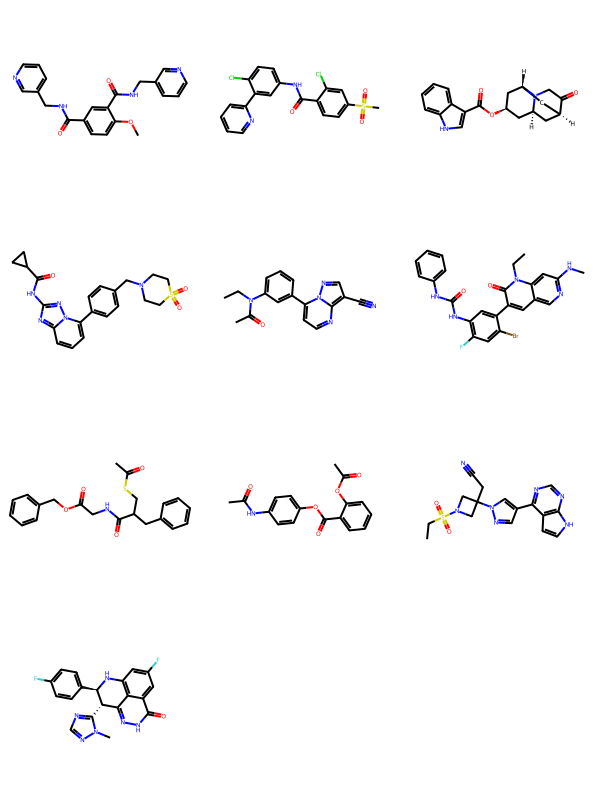

In [117]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in swiss_df.SMILES.values[0:10]])

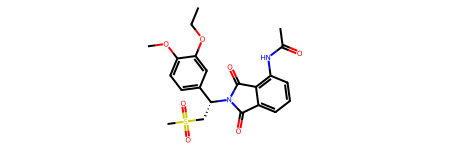

In [120]:
Chem.MolFromSmiles(swiss_df.query("index == 10").SMILES.values[0])

In [121]:
swiss_df.SMILES.values[0:10]

array(['COc1ccc(C(=O)NCc2cccnc2)cc1C(=O)NCc1cccnc1',
       'CS(=O)(=O)c1ccc(C(=O)Nc2ccc(Cl)c(-c3ccccn3)c2)c(Cl)c1',
       'O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c1c[nH]c2ccccc12',
       'O=C(Nc1nc2cccc(-c3ccc(CN4CCS(=O)(=O)CC4)cc3)n2n1)C1CC1',
       'CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1',
       'CCn1c(=O)c(-c2cc(NC(=O)Nc3ccccc3)c(F)cc2Br)cc2cnc(NC)cc21',
       'CC(=O)SCC(Cc1ccccc1)C(=O)NCC(=O)OCc1ccccc1',
       'CC(=O)Nc1ccc(OC(=O)c2ccccc2OC(C)=O)cc1',
       'CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1',
       'Cn1ncnc1[C@H]1c2n[nH]c(=O)c3cc(F)cc(c23)N[C@@H]1c1ccc(F)cc1'],
      dtype=object)

In [122]:
swiss_df.query("SMILES == 'Cn1ncnc1[C@H]1c2n[nH]c(=O)c3cc(F)cc(c23)N[C@@H]1c1ccc(F)cc1'")

,S_method,Molecule_ID,Score,SMILES,pref_name
9,3D - Electroshape,CHEMBL3137318,0.856,Cn1ncnc1[C@H]1c2n[nH]c(=O)c3cc(F)cc(c23)N[C@@H...,TALAZOPARIB TOSYLATE
19,3D - Electroshape,CHEMBL3137320,0.849,Cn1ncnc1[C@H]1c2n[nH]c(=O)c3cc(F)cc(c23)N[C@@H...,TALAZOPARIB


### Lig docking

In [2]:
! pwd

/home/ramin/Desktop/personal/cheminfo/met


In [4]:
ligands_df = pd.read_csv("./cleaner_to_dock.csv")

In [31]:
ligands_df.head()

,molecule_chembl_id,SMILES,method
0,CHEMBL1257015,COc1ccc(C(=O)NCc2cccnc2)cc1C(=O)NCc1cccnc1,swiss
1,CHEMBL473417,CS(=O)(=O)c1ccc(C(=O)Nc2ccc(Cl)c(-c3ccccn3)c2)...,swiss
2,CHEMBL2368925,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,swiss
3,CHEMBL3301607,O=C(Nc1nc2cccc(-c3ccc(CN4CCS(=O)(=O)CC4)cc3)n2...,swiss
4,CHEMBL1521,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,swiss


In [32]:
! pwd

/home/ramin/Desktop/personal/cheminfo/met/savolotinib_6SDE


In [33]:
ligands_df.head()

,molecule_chembl_id,SMILES,method
0,CHEMBL1257015,COc1ccc(C(=O)NCc2cccnc2)cc1C(=O)NCc1cccnc1,swiss
1,CHEMBL473417,CS(=O)(=O)c1ccc(C(=O)Nc2ccc(Cl)c(-c3ccccn3)c2)...,swiss
2,CHEMBL2368925,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,swiss
3,CHEMBL3301607,O=C(Nc1nc2cccc(-c3ccc(CN4CCS(=O)(=O)CC4)cc3)n2...,swiss
4,CHEMBL1521,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,swiss


In [ ]:
fixable.get(

In [42]:
ligands_df = (ligands_df
 .assign(
     SMILES = lambda df: df.apply(lambda row: fixable.get(row['molecule_chembl_id'], row['SMILES']), axis=1)
 )
)

In [43]:
ligands_df['mol'] = ligands_df['SMILES'].apply(Chem.MolFromSmiles)

In [44]:
ligands_df.head()

,molecule_chembl_id,SMILES,method,mol
0,CHEMBL1257015,COc1ccc(C(=O)NCc2cccnc2)cc1C(=O)NCc1cccnc1,swiss,<rdkit.Chem.rdchem.Mol object at 0x7338b8dd0d60>
1,CHEMBL473417,CS(=O)(=O)c1ccc(C(=O)Nc2ccc(Cl)c(-c3ccccn3)c2)...,swiss,<rdkit.Chem.rdchem.Mol object at 0x7338b8dd0890>
2,CHEMBL2368925,[H]C35C[C@@]4([H])CC(OC(=O)c1c[nH]c2ccccc12)C[...,swiss,<rdkit.Chem.rdchem.Mol object at 0x7338b8dd0820>
3,CHEMBL3301607,O=C(Nc1nc2cccc(-c3ccc(CN4CCS(=O)(=O)CC4)cc3)n2...,swiss,<rdkit.Chem.rdchem.Mol object at 0x7338b8dd0c80>
4,CHEMBL1521,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,swiss,<rdkit.Chem.rdchem.Mol object at 0x7338b8dd09e0>


In [45]:
failed = []
for row in ligands_df.values:
    os.mkdir(row[0])
    try:
        ligand_prep(row[3], out=f"{row[0]}/l")
    except Exception as e:
        os.removedirs(row[0])
        failed.append(row)

[15:50:38] UFFTYPER: Unrecognized charge state for atom: 8
[15:50:38] UFFTYPER: Unrecognized charge state for atom: 8
[15:50:38] UFFTYPER: Unrecognized charge state for atom: 8
[15:50:38] UFFTYPER: Unrecognized charge state for atom: 8
[15:50:44] UFFTYPER: Unrecognized charge state for atom: 14
[15:51:02] UFFTYPER: Unrecognized charge state for atom: 12
[15:51:11] UFFTYPER: Unrecognized charge state for atom: 8
[15:51:12] UFFTYPER: Unrecognized charge state for atom: 54
[15:52:05] UFFTYPER: Unrecognized charge state for atom: 14
[15:52:12] UFFTYPER: Unrecognized charge state for atom: 4
[15:52:38] UFFTYPER: Unrecognized charge state for atom: 5
[15:52:43] UFFTYPER: Unrecognized charge state for atom: 21
[15:53:23] UFFTYPER: Unrecognized charge state for atom: 12


In [46]:
len(failed)

17

##### dock for wild type

In [48]:
len([x for x in os.listdir() if x.startswith('CH')])

1080

In [51]:
os.path.exists('CHEMBL1000/l.pdbqt')

True

In [59]:
import shutil

In [61]:
([x for x in os.listdir() if x.startswith("CH")][0])

True

In [62]:
for dir_ in [x for x in os.listdir() if x.startswith("CH")]:
    shutil.copy2("./wild/r.pdbqt", dir_)

wrtie gpf to wild types

In [63]:
failed_ = []
for dir_ in [x for x in os.listdir() if x.startswith("CH")]:
    if os.path.exists(f"{dir_}/l.pdbqt"):
        write_vinaconf_gpf(lPDBQT=f"{dir_}/l.pdbqt", rPDBQT=f"{dir_}/r.pdbqt", v_out=f"{dir_}/v.txt", gpf_out=f"{dir_}/r.gpf", p=10)
    else:
        failed_.append(dir_)

In [69]:
os.getcwd()

'/home/ramin/Desktop/personal/cheminfo/met/savolotinib_6SDE'

In [70]:
failed_grid = []
for dir_ in [x for x in os.listdir() if x.startswith("CH")]:
    if os.path.exists(f"{dir_}/r.gpf"):
        os.chdir(dir_)
        run_autogrid("r.gpf", glgout="r.glg")
        os.chdir("../")
    else:
        failed_grid.append(dir_)

success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map files created sucsussfully!
success, map fil

In [27]:
! pwd

/home/ramin/Desktop/personal/cheminfo/met/savolotinib_6SDE


In [65]:
os.chdir("../")

In [9]:
from tqdm.auto import tqdm

In [21]:
to_dock_dirs = [x for x in os.listdir() if x.startswith("CH")]

In [64]:
os.getcwd()

'/home/ramin/Desktop/personal/cheminfo/met/savolotinib_6SDE/CHEMBL3301607'

In [66]:
for dir_ in tqdm(to_dock_dirs, total=len(to_dock_dirs)):
    print(f"Docking in {dir_}")
    os.chdir(dir_)
    command = f"/home/ramin/Downloads/AutoDock-GPU/bin/autodock_gpu_64wi --lfile l.pdbqt --ffile r.maps.fld --nrun 50 --resnam l_wild"
    
    try:
        # Run the command and wait for it to complete
        result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        #print(f"Command output: {result.stdout}")
        if result.stderr:
            print(f"Command stderr: {str(result.stderr)}")
    except subprocess.CalledProcessError as e:
        print(f"Command failed with error: {e}")
        print(f"Error output: {e.stderr}")
    
    os.chdir("../")

  0%|          | 0/1080 [00:00<?, ?it/s]

Docking in CHEMBL1257015
Docking in CHEMBL473417
Docking in CHEMBL2368925
Docking in CHEMBL3301607
Docking in CHEMBL1521
Docking in CHEMBL4216467
Docking in CHEMBL2103772
Docking in CHEMBL162036
Docking in CHEMBL2105759
Docking in CHEMBL3137318
Docking in CHEMBL514800
Docking in CHEMBL343448
Docking in CHEMBL1522
Docking in CHEMBL1233
Docking in CHEMBL135400
Docking in CHEMBL9967
Docking in CHEMBL2103875
Docking in CHEMBL1771
Docking in CHEMBL2107386
Docking in CHEMBL779
Docking in CHEMBL19224
Docking in CHEMBL4297526
Docking in CHEMBL277062
Docking in CHEMBL3989833
Docking in CHEMBL521686
Docking in CHEMBL1201168
Docking in CHEMBL3989786
Docking in CHEMBL1256841
Docking in CHEMBL407
Docking in CHEMBL2104445
Docking in CHEMBL628
Docking in CHEMBL3183075
Docking in CHEMBL1402684
Docking in CHEMBL1200470
Docking in CHEMBL1201056
Docking in CHEMBL2216870
Docking in CHEMBL1503
Docking in CHEMBL1201320
Docking in CHEMBL1567328
Docking in CHEMBL297302
Docking in CHEMBL45
Docking in CHEMBL190

KeyboardInterrupt: 

In [24]:
! pwd

/home/ramin/Desktop/personal/cheminfo/met/savolotinib_6SDE/CHEMBL1257015
